In [1]:
import matplotlib.pyplot as plt
import numpy             as np

from tqdm                 import tqdm
from astropy              import units, constants

from p3droslo.utils       import convert_angular_to_spatial
from p3droslo.plot        import plot_cube_2D
from p3droslo.object      import AstroObject
from p3droslo.observation import DataCube

from p3droslo.model       import TensorModel, SphericallySymmetric
from p3droslo.utils       import print_var, interpolate
from p3droslo.lines       import Line
from p3droslo.loss        import Loss, fourier_loss_1D, fourier_loss_1D
from p3droslo.haar        import Haar

In [63]:
depth = 100

model = TensorModel(shape=(depth,), sizes=(10.0,))

model['CO'          ] = 1.0e+5 * np.ones(depth)
model['temperature' ] = 2.0e+2 * np.ones(depth)
# model['velocity_z'  ] = 0.0    * np.ones(depth)
model['velocity_z'  ] = 5.0e+3 * np.linspace(-1.0, +1.0, depth)

model['v_turbulence'] = 1.5e+2 * np.ones(depth)

In [64]:
import torch
import torch.nn as nn

from torch.optim import Adam

In [65]:
# Model Hyperparameters
cuda   = False
DEVICE = torch.device("cuda" if cuda else "cpu")

In [66]:
line = Line('CO', 0)

You have selected line:
    CO(J=1-0)
Please check the properties that were inferred:
    Frequency         1.152712018e+11  Hz
    Einstein A coeff  7.203000000e-08  1/s
    Molar mass        28.0101          g/mol


In [67]:
from astropy import constants

CC  = constants.c  .si.value   # Speed of light       [m/s]

def get_doppler_shifted_frequencies(v_los, frequencies):
    """
    Doppler shifts frequencies given the velocity along the line of sight.
    """
    # Compute the Doppler shift for each cell
    shift = 1.0 + v_los * (1.0 / CC)

    # Create freqency tensor for each cell
    freqs = torch.einsum("..., f -> ...f", shift, frequencies)
    
    return freqs

In [68]:
def forward(model, freqs):
    """
    Forward model: image the given TensorModel at the given frequencies.
    """
    nCO    = model['CO']
    tmp    = model['temperature']
    vel    = model['velocity_z']
    v_turb = model['v_turbulence']
    
    frequencies = get_doppler_shifted_frequencies(vel, freqs)
    
    # Compute the LTE line emissivity and opacity, and the line profile
    eta, chi = line.LTE_emissivity_and_opacity(nCO, tmp, v_turb, frequencies)
    
    # Create an image of the line
    img = model.create_image(eta, chi, axis=0)
    
    # Convolve with beam
    # img = convolve_with_beam(img)
    
    # Resolved out flux
    # img = resolved_out_flux(img)
    
    return img

In [69]:
N_freqs = 500
v_pixel = 25.0

dd    = (N_freqs-1)/2 * v_pixel/constants.c.si.value
fmin  = line.frequency - line.frequency*dd
fmax  = line.frequency + line.frequency*dd
freqs = torch.linspace(fmin, fmax, N_freqs, dtype=torch.float64)

In [70]:
with torch.no_grad():
    img_p = forward(model, freqs)

LTE pop   0.0007469654083251953
Eins A B  0.0005307197570800781
profile   0.0009644031524658203
multiply  0.0002961158752441406


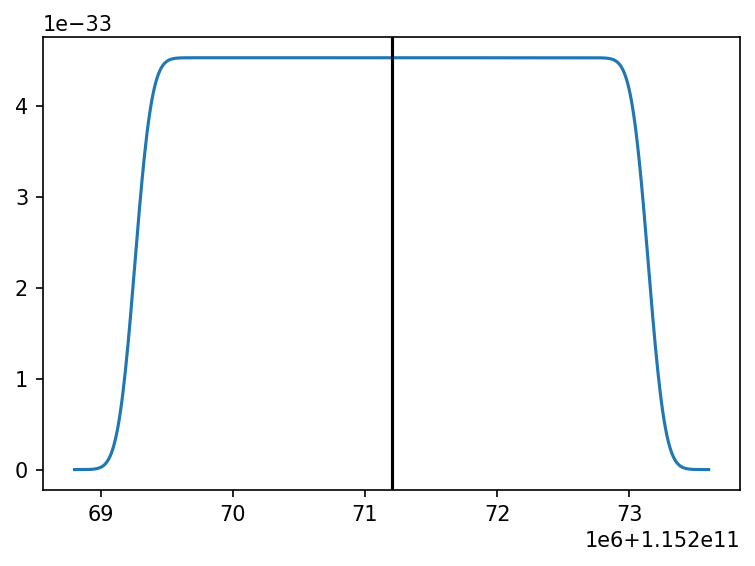

In [71]:
plt.figure(dpi=150)
plt.plot(freqs, img_p.data)
plt.axvline(line.frequency, c='k')